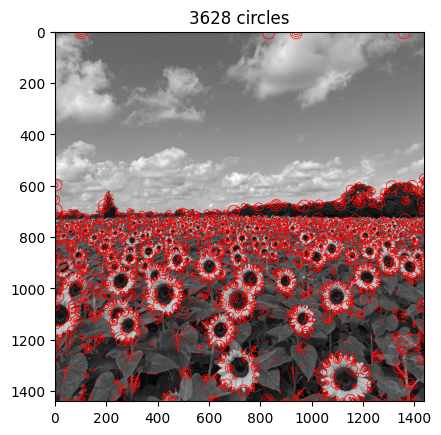

Run time = 13.630810737609863s


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import fft2d
import time
import math
from math import sqrt
from scipy import spatial

class laplaceScaleSpace():
    def __init__(self):
        # default values (Initialization only)
        self.numScales = 10
        self.k = 1.25
        self.sigma = 0.5
        self.thresh_percent = 0.035 
        self.debug = 0
        self.output_filename = 'result.jpg'
        
        self.trans = fft2d.fourier()
        self.scaleSpace = []
        self.blobMarkers = []  
        self.newImg = []
        self.radiiByScale = []
        
    def convolveImg(self, image, kernel):
        m,n = image.shape
        p,q = kernel.shape
        
        ## Align the kernel to the center of the image
        paddedKernel = np.zeros((m,n), dtype='float64')
        try:
            paddedKernel[int(m/2)-int(p/2):int(m/2)+int(p/2)+1, int(n/2)-int(q/2):int(n/2)+int(q/2)+1] = kernel
        except ValueError:
            paddedKernel[int(m/2)-int(p/2):int(m/2)+int(p/2), int(n/2)-int(q/2):int(n/2)+int(q/2)] = kernel
            
        result = self.trans.dft(image.astype('float64')/255.)*self.trans.dft(paddedKernel.astype('float64'))
        newImg = np.fft.fftshift(np.absolute(self.trans.idft(result)))
        return newImg
    
    def computeScaleSpace(self, img):
        m,n = img.shape
        if self.debug:
            print('Round, Sigma Value, ScaleSpaceShape')
            
        for i in range(0, self.numScales):
            scaledsigma = self.sigma * self.k ** (i)
            self.kernel = fft2d.gkern(scaledsigma)
            self.newImg.append(self.convolveImg(img, self.kernel))
            
            if i > 0:
                self.scaleSpace.append(np.square(self.newImg[i]-self.newImg[i-1]))
                if self.debug:
                    print(i, scaledsigma, np.shape(self.scaleSpace))
                    
        self.radiiByScale = [(i-1)*(20/(self.numScales-2))+2.5 for i in range(1, self.numScales)]

    def getNMS2D(self, img): 
        thresh_limit = (np.max(img)-np.min(img))*self.thresh_percent
        
        kernel = np.ones((3, 3), dtype='float64')
        dilated = cv2.dilate(img, kernel, iterations=1)
        
        maxima = (img==dilated)*img >= thresh_limit
        return maxima
        
    def getNMS3D(self, scaleSpace2D):
        maxvalNeighbors = np.copy(scaleSpace2D)
        if self.debug:
            print(np.shape(maxvalNeighbors))
        for i in range(0,(self.numScales-1)):
            if i == 0:
                lowScale = i
                upperScale = i+1
            elif i < (self.numScales-2):
                lowScale = i-1
                upperScale = i+1
            else:
                lowScale = i-1
                upperScale = i
                
            maxvalNeighbors[i,:,:] = np.amax(maxvalNeighbors[lowScale:upperScale+1,:,:], axis=0)
        
        originalValMarkers = maxvalNeighbors == scaleSpace2D
        if self.debug:
            print(np.shape(originalValMarkers))
        self.scaleSpace3DNMS = np.multiply(maxvalNeighbors, originalValMarkers) 
    
    
    def detectBlobs(self, image, NumScales=10, k=1.25, sigma=0.5, thresh_percent=0.035):
        self.numScales = NumScales
        self.k = k
        self.sigma = sigma
        self.thresh_percent = thresh_percent
        
        self.scaleSpace2DNMS = [[] for i in range(self.numScales-1)]
        
        ## Laplacian scale space computation
        self.computeScaleSpace(image)
        if self.debug:
            print('Completed - ScaleSpace')
        
        # 2D NMS computation
        for i in range(0,len(self.scaleSpace)): 
            self.scaleSpace2DNMS[i] = self.getNMS2D(np.array(self.scaleSpace[i]))
        if self.debug:
            print('Completed - NMS/threshold')
        
        self.getNMS3D( self.scaleSpace2DNMS)
        
        self.displayCircles(image)
        
    def retblobmarkers(self):  
        if self.debug:
            print('Round, TotalMaxima in ScaleSpace, TotalBlobMarkers')
        for i in range(0,len(self.scaleSpace3DNMS)):
            # Finds the location of maxima in the scale space
            inds = np.where(self.scaleSpace3DNMS[i] > 0)
            x = [self.radiiByScale[i] for t in range(0,len(inds[0]))]
            
            markers = np.zeros((3,len(inds[0])))
            markers[0]=inds[0]
            markers[1]=inds[1]
            markers[2]=x
            markers = np.transpose(markers)
            markers = self.redundancy(markers, 0.001) #0.001

            if i == 0:
                self.blobMarkers = markers
            else:
                self.blobMarkers = np.append(self.blobMarkers, markers, axis=0)
            
            if self.debug:
                print(i, np.shape(inds), np.shape(self.blobMarkers), self.radiiByScale[i])
        if self.debug:
            print('Completed - Blob Markers')
                
    def displayCircles(self, image): 
        self.retblobmarkers()
        from matplotlib.patches import Circle
        
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(image, cmap='gray')
        
        for coord in self.blobMarkers:
            
            circ = Circle((coord[1],coord[0]), coord[2], color='r', linewidth=0.5, fill=False)
            ax.add_patch(circ)
            
        plt.title('%i circles' % len(self.blobMarkers))
        plt.show()

    def blob_overlap(self, blob1, blob2):
        n_dim = len(blob1) - 1
        root_ndim = sqrt(n_dim)
        
        # radius of two blobs
        r1 = blob1[-1] * root_ndim
        r2 = blob2[-1] * root_ndim
        
        d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
        
        #no overlap between two blobs
        if d > r1 + r2:
            return 0
        elif d <= abs(r1 - r2):
            return 1
        else:
            #computing the area of overlap between blobs
            ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
            ratio1 = np.clip(ratio1, -1, 1)
            acos1 = math.acos(ratio1)
            ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
            ratio2 = np.clip(ratio2, -1, 1)
            acos2 = math.acos(ratio2)
            a = -d + r2 + r1
            b = d - r2 + r1
            c = d + r2 - r1
            d = d + r2 + r1
            area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
            return area/(math.pi * (min(r1, r2) ** 2))
        
    def redundancy(self, blobs_array, overlap):
        sigma = blobs_array[:, -1].max()
        distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
        
        # Binary search to determine all possible pairs of circles for overlap checking
        tree = spatial.cKDTree(blobs_array[:, :-1])
        pairs = np.array(list(tree.query_pairs(distance)))
        if len(pairs) == 0:
            return blobs_array
        else:
            for (i, j) in pairs:
                blob1, blob2 = blobs_array[i], blobs_array[j]
                if self.blob_overlap(blob1, blob2) > overlap:
                    if blob1[-1] > blob2[-1]:
                        blob2[-1] = 0
                    else:
                        blob1[-1] = 0
        return np.array([b for b in blobs_array if b[-1] > 0])
    
    
###########
#######
### DRIVER CODE
#######
###########
    
## Enter the filename for running the blob detection code

filename = 'images\\the_berry_farms_sunflower_field.jpeg'
img = cv2.imread(filename, 0)        

t1 = time.time()
obj = laplaceScaleSpace()
obj.debug = 0 # 1 creates verbose output
obj.output_filename = 'result-'+filename

# Function Parameter Values
# detectBlobs(img, NumScales=10, k=1.25, sigma=0.5, thresh_percent=0.035

if filename == 'butterfly.jpg':
    obj.detectBlobs(img, 5, 1.375*2, 0.78125, 0.013)  #butterfly
elif filename == 'fishes.jpg':
    obj.detectBlobs(img, 4, 1.375*1.5, 0.5, 0.02)  #fishes
elif filename == 'images\\the_berry_farms_sunflower_field.jpeg':
    obj.detectBlobs(img, 5, 1.45, 0.5, 0.1)  #sunflowers
elif filename == 'einstein.jpg':
    obj.detectBlobs(img, 5, 2.25, 0.5625, 0.03)  #einstein
else:
    print('Please enter an appropriate filename')

print("Run time = {}s".format(time.time()-t1))